In [22]:
import torch
import torch.nn as nn
from torchvision.datasets import FGVCAircraft
from torchvision import transforms
from torch.utils.data import DataLoader

from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt

from custom_dataset import FGVCAircraftAugmented
from core.models.nts_net import NTSModel
from core.loss import list_loss, ranking_loss

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Training

In [24]:
OUT_DIR = "results"

IMAGE_WIDTH = IMAGE_HEIGHT = 224
NUM_WORKERS = 0

PROPOSAL_NUM = 6
CAT_NUM = 4

BATCH_SIZE = 8
LR = 0.001
WEIGHT_DECAY = 1e-4
MOMENTUM = 0.9
NUM_EPOCHS = 5

In [25]:
from torchvision.transforms import Compose, Normalize, Resize, ToTensor, RandomHorizontalFlip, RandomCrop, RandomPerspective, GaussianBlur
from torch.utils.data import DataLoader, ConcatDataset
from PIL import Image
import torch.utils.data as data_utils

indices = torch.arange(1_000)

img_mean, img_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

transform = Compose([
  Resize((IMAGE_HEIGHT, IMAGE_WIDTH), Image.BILINEAR),
  ToTensor(),
  Normalize(mean=img_mean, std=img_std),
])

target_transform = ToTensor()

augmentations = {'horizontal_flip': transforms.RandomHorizontalFlip(p=1.0)}

# Load data
root = 'data'
val_data = FGVCAircraft(root=root, split="val", transform=transform, download=True)
n_classes = len(val_data.classes)
val_data = data_utils.Subset(val_data, indices)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [26]:
from torch.optim.lr_scheduler import MultiStepLR

def train_model(train_loader, val_loader, experiment_name, num_epochs=5):
  #val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

  model = NTSModel(top_n=PROPOSAL_NUM, n_classes=n_classes).to(device)
  criterion = torch.nn.CrossEntropyLoss()

  # Setup optimizers
  resnet_parameters = list(model.resnet.parameters())
  navigator_parameters = list(model.navigator.parameters())
  concat_parameters = list(model.concat_net.parameters())
  partcls_parameters = list(model.partcls_net.parameters())

  resnet_optimizer = torch.optim.SGD(resnet_parameters, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  navigator_optimizer = torch.optim.SGD(navigator_parameters, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  concat_optimizer = torch.optim.SGD(concat_parameters, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  partcls_optimizer = torch.optim.SGD(partcls_parameters, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)


  # Setup learning rate scheduler
  scheduler_interval = [int(num_epochs * 0.5), int(num_epochs * 0.75)]
  scheduler_gamma = 0.1

  schedulers = [MultiStepLR(resnet_optimizer, milestones=scheduler_interval, gamma=scheduler_gamma),
                MultiStepLR(navigator_optimizer, milestones=scheduler_interval, gamma=scheduler_gamma),
                MultiStepLR(concat_optimizer, milestones=scheduler_interval, gamma=scheduler_gamma),
                MultiStepLR(partcls_optimizer, milestones=scheduler_interval, gamma=scheduler_gamma)]

  model = nn.DataParallel(model)

  ########################### TRAIN ##################################
  history = {
      "train_loss": [],
      "val_loss": [],
      "train_accuracy": [],
      "val_accuracy": [],
  }

  for epoch in range(num_epochs):
      epoch_loss = 0
      epoch_accuracy = 0
      epoch_val_loss = 0
      epoch_val_accuracy = 0
      with tqdm(total=len(train_loader)) as pbar:
          for i, (inputs, labels) in enumerate(train_loader):
              inputs, labels = inputs.to(device), labels.to(device)
              batch_size = inputs.size(0)

              resnet_optimizer.zero_grad()
              navigator_optimizer.zero_grad()
              concat_optimizer.zero_grad()
              partcls_optimizer.zero_grad()

              resnet_logits, concat_logits, part_logits, top_n_idxs, top_n_proba = model(inputs)
              
              # Losses
              resnet_loss = criterion(resnet_logits, labels)
              navigator_loss = list_loss(part_logits.view(batch_size * PROPOSAL_NUM, -1),
                                      labels.unsqueeze(1).repeat(1, PROPOSAL_NUM).view(-1)).view(batch_size, PROPOSAL_NUM)
              concat_loss = criterion(concat_logits, labels)
              rank_loss = ranking_loss(top_n_proba, navigator_loss, proposal_num=PROPOSAL_NUM)
              partcls_loss = criterion(part_logits.view(batch_size * PROPOSAL_NUM, -1),
                                  labels.unsqueeze(1).repeat(1, PROPOSAL_NUM).view(-1))
              
              loss = resnet_loss + concat_loss + rank_loss + partcls_loss
              loss.backward()

              resnet_optimizer.step()
              navigator_optimizer.step()
              concat_optimizer.step()
              partcls_optimizer.step()

              accuracy = (concat_logits.argmax(dim=1) == labels).float().mean()
              
              epoch_loss += concat_loss.item()
              epoch_accuracy += accuracy.item()

              pbar.set_postfix_str("Train loss: {:.4f}, Train accuracy: {:.4f}".format(epoch_loss / (i+1), epoch_accuracy / (i+1)))
              pbar.update(1)
      for scheduler in schedulers:
        scheduler.step()
      
      with tqdm(total=(len(val_loader))) as pbar:
        with torch.no_grad():
          for i, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            batch_size = inputs.size(0)

            _, concat_logits, _, _, _ = model(inputs)

            concat_loss = criterion(concat_logits, labels)


            accuracy = (concat_logits.argmax(dim=1) == labels).float().mean()

            epoch_val_loss += concat_loss.item()
            epoch_val_accuracy += accuracy.item()


            pbar.set_postfix_str("Val loss: {:.4f}, Val accuracy: {:.4f}".format(epoch_val_loss / (i+1), epoch_val_accuracy / (i+1)))
            pbar.update(1)

        epoch_val_loss = epoch_val_loss/len(val_loader)
        history["val_loss"].append(epoch_val_loss)
        epoch_val_accuracy = epoch_val_accuracy/len(val_loader)
        history["val_accuracy"].append(epoch_val_accuracy) 

      epoch_loss = epoch_loss/len(train_loader)
      epoch_accuracy = epoch_accuracy/len(train_loader)
      history["train_loss"].append(epoch_loss)
      history["train_accuracy"].append(epoch_accuracy)

      print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.4f} - Val Loss: {epoch_val_loss:.4f} - Val Accuracy: {epoch_val_accuracy:.4f}")


  # Save model weights
  out_path = os.path.join(OUT_DIR)
  if not os.path.exists(out_path):
    os.mkdir(out_path)

  torch.save({
      "train_accuracy": history["train_accuracy"][-1],
      "val_accuracy": history["val_accuracy"][-1]
  }, os.path.join(out_path, f"{experiment_name}.ckpt"))

# Experiments

In [27]:
indices_500 = torch.arange(500)

td_plain = data_utils.Subset(FGVCAircraft(root=root, split="train", transform=transform), indices_500)
plain_loader = DataLoader(td_plain, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

td_ver_flip = data_utils.Subset(FGVCAircraftAugmented(root=root, split="train", transform=transform, augmentations={'vertical_flip': transforms.RandomVerticalFlip(p=1.0)}), indices)
ver_flip_loader = DataLoader(td_ver_flip, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

td_hor_flip = data_utils.Subset(FGVCAircraftAugmented(root=root, split="train", transform=transform, augmentations={'horizontal_flip': transforms.RandomHorizontalFlip(p=1.0)}), indices)
hor_flip_loader = DataLoader(td_hor_flip, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

td_rot = data_utils.Subset(FGVCAircraftAugmented(root=root, split="train", transform=transform, augmentations={'rotate': transforms.RandomRotation((-180, 180))}), indices)
rot_loader = DataLoader(td_rot, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

td_crop = data_utils.Subset(FGVCAircraftAugmented(root=root, split="train", transform=transform, augmentations={'crop': transforms.RandomCrop((200, 200))}), indices)
crop_loader = DataLoader(td_crop, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

td_col_jit = data_utils.Subset(FGVCAircraftAugmented(root=root, split="train", transform=transform, augmentations={'jitter': transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)}), indices)
jit_loader = DataLoader(td_col_jit, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

td_gaus_noise = data_utils.Subset(FGVCAircraftAugmented(root=root, split="train", transform=transform, augmentations={'gaus': transforms.GaussianBlur(kernel_size=3)}), indices)
gaus_loader = DataLoader(td_gaus_noise, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [32]:
#Uncomment to train
#train_model(plain_loader, val_loader, "plain")
#train_model(ver_flip_loader, val_loader, "vertical_flip")
#train_model(hor_flip_loader, val_loader, "horizontal_flip")
#train_model(rot_loader, val_loader, "rotate")
#train_model(crop_loader, val_loader, "crop")
#train_model(jit_loader, val_loader, "jitter")
#train_model(gaus_loader, val_loader, "gaus")

'Uncomment to train\ntrain_model(plain_loader, val_loader, "plain")\ntrain_model(ver_flip_loader, val_loader, "vertical_flip")\ntrain_model(hor_flip_loader, val_loader, "horizontal_flip")\ntrain_model(rot_loader, val_loader, "rotate")\ntrain_model(crop_loader, val_loader, "crop")\ntrain_model(jit_loader, val_loader, "jitter")\ntrain_model(gaus_loader, val_loader, "gaus")\n'

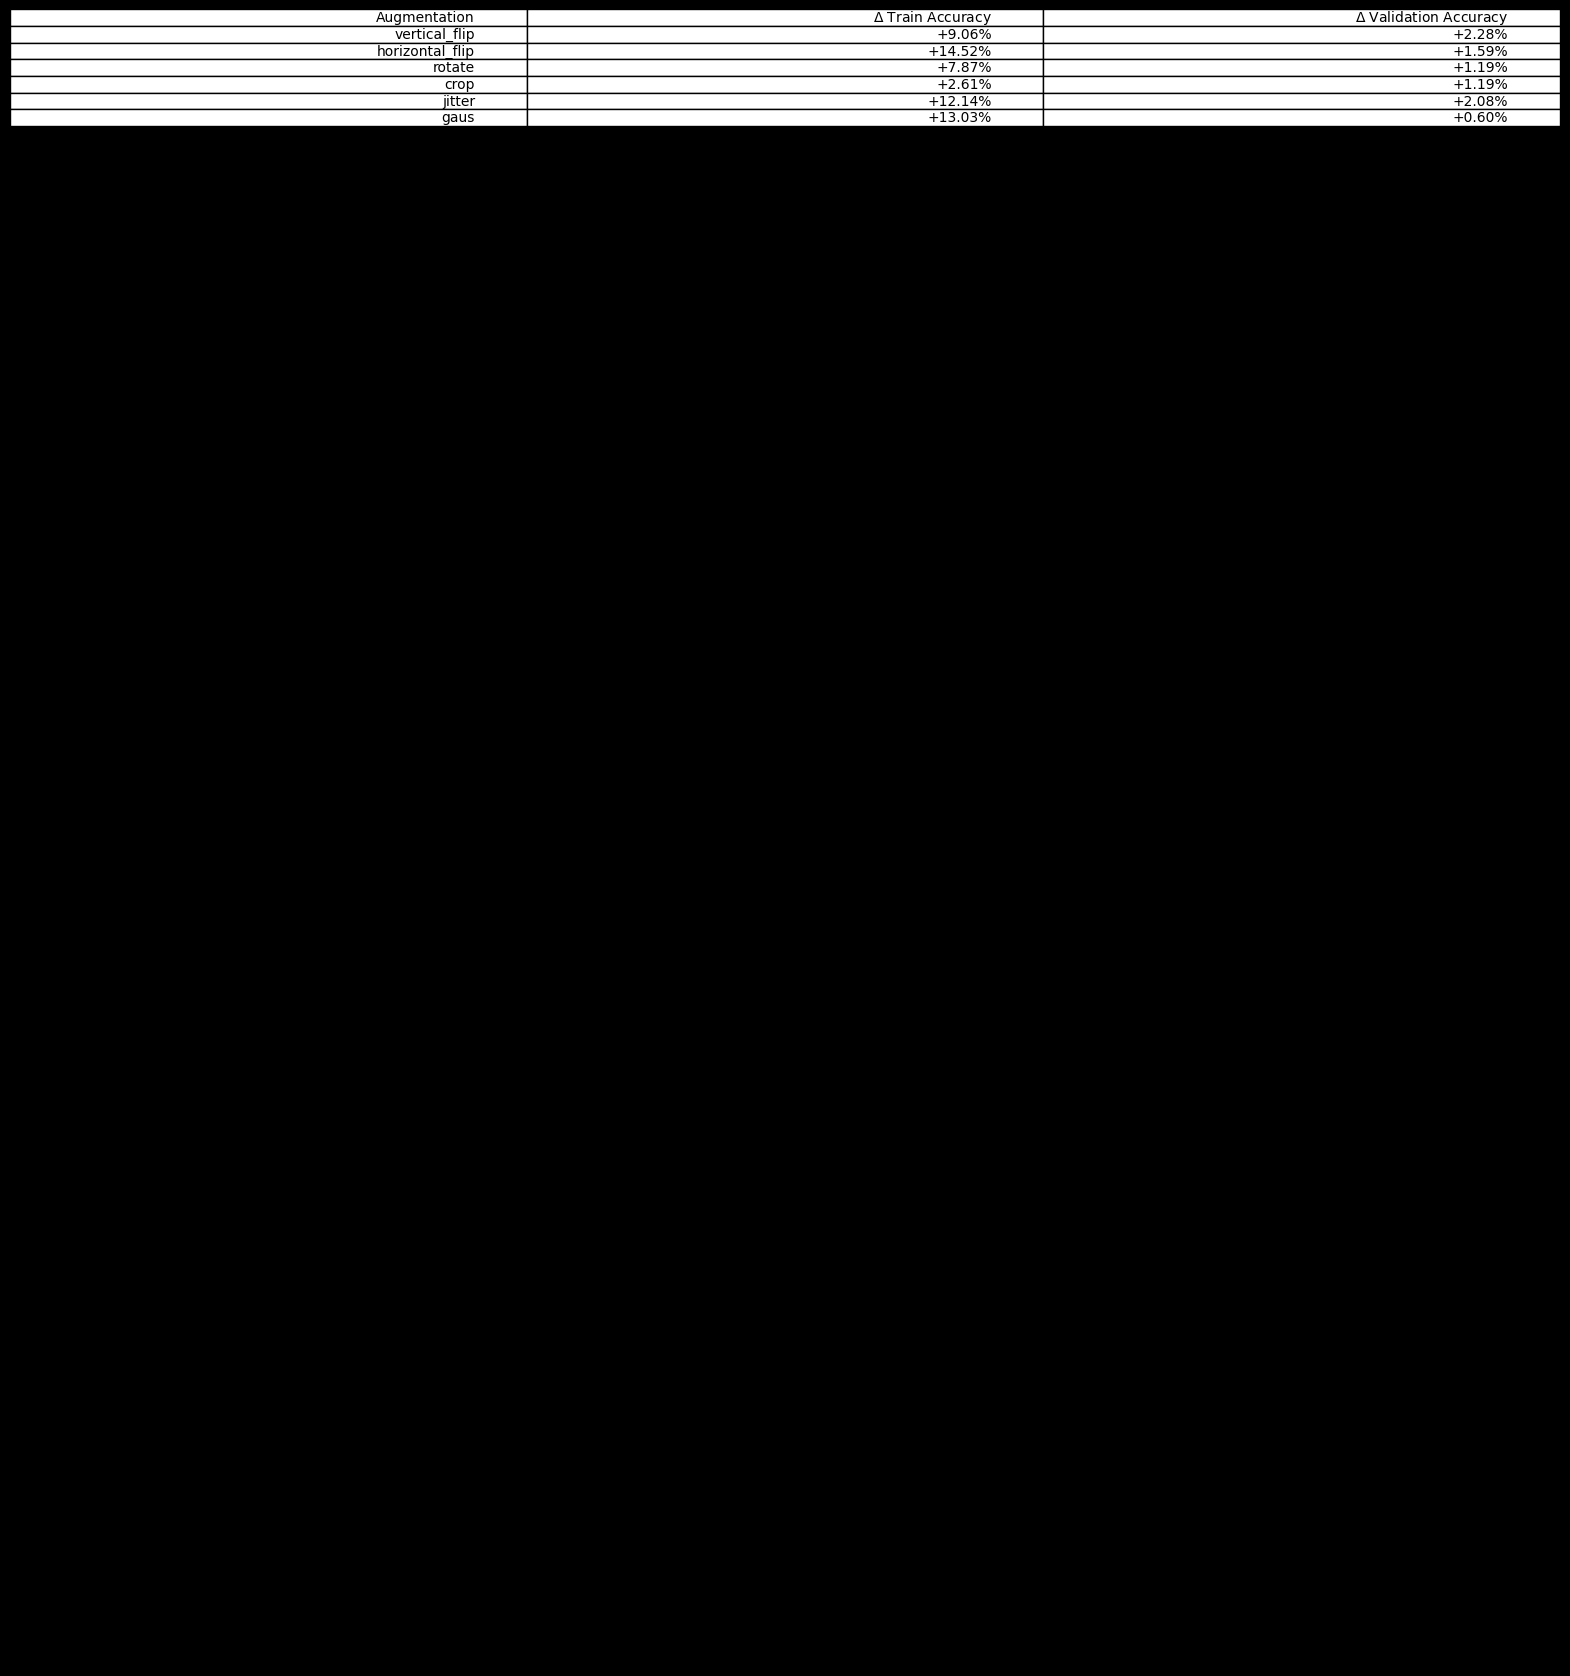

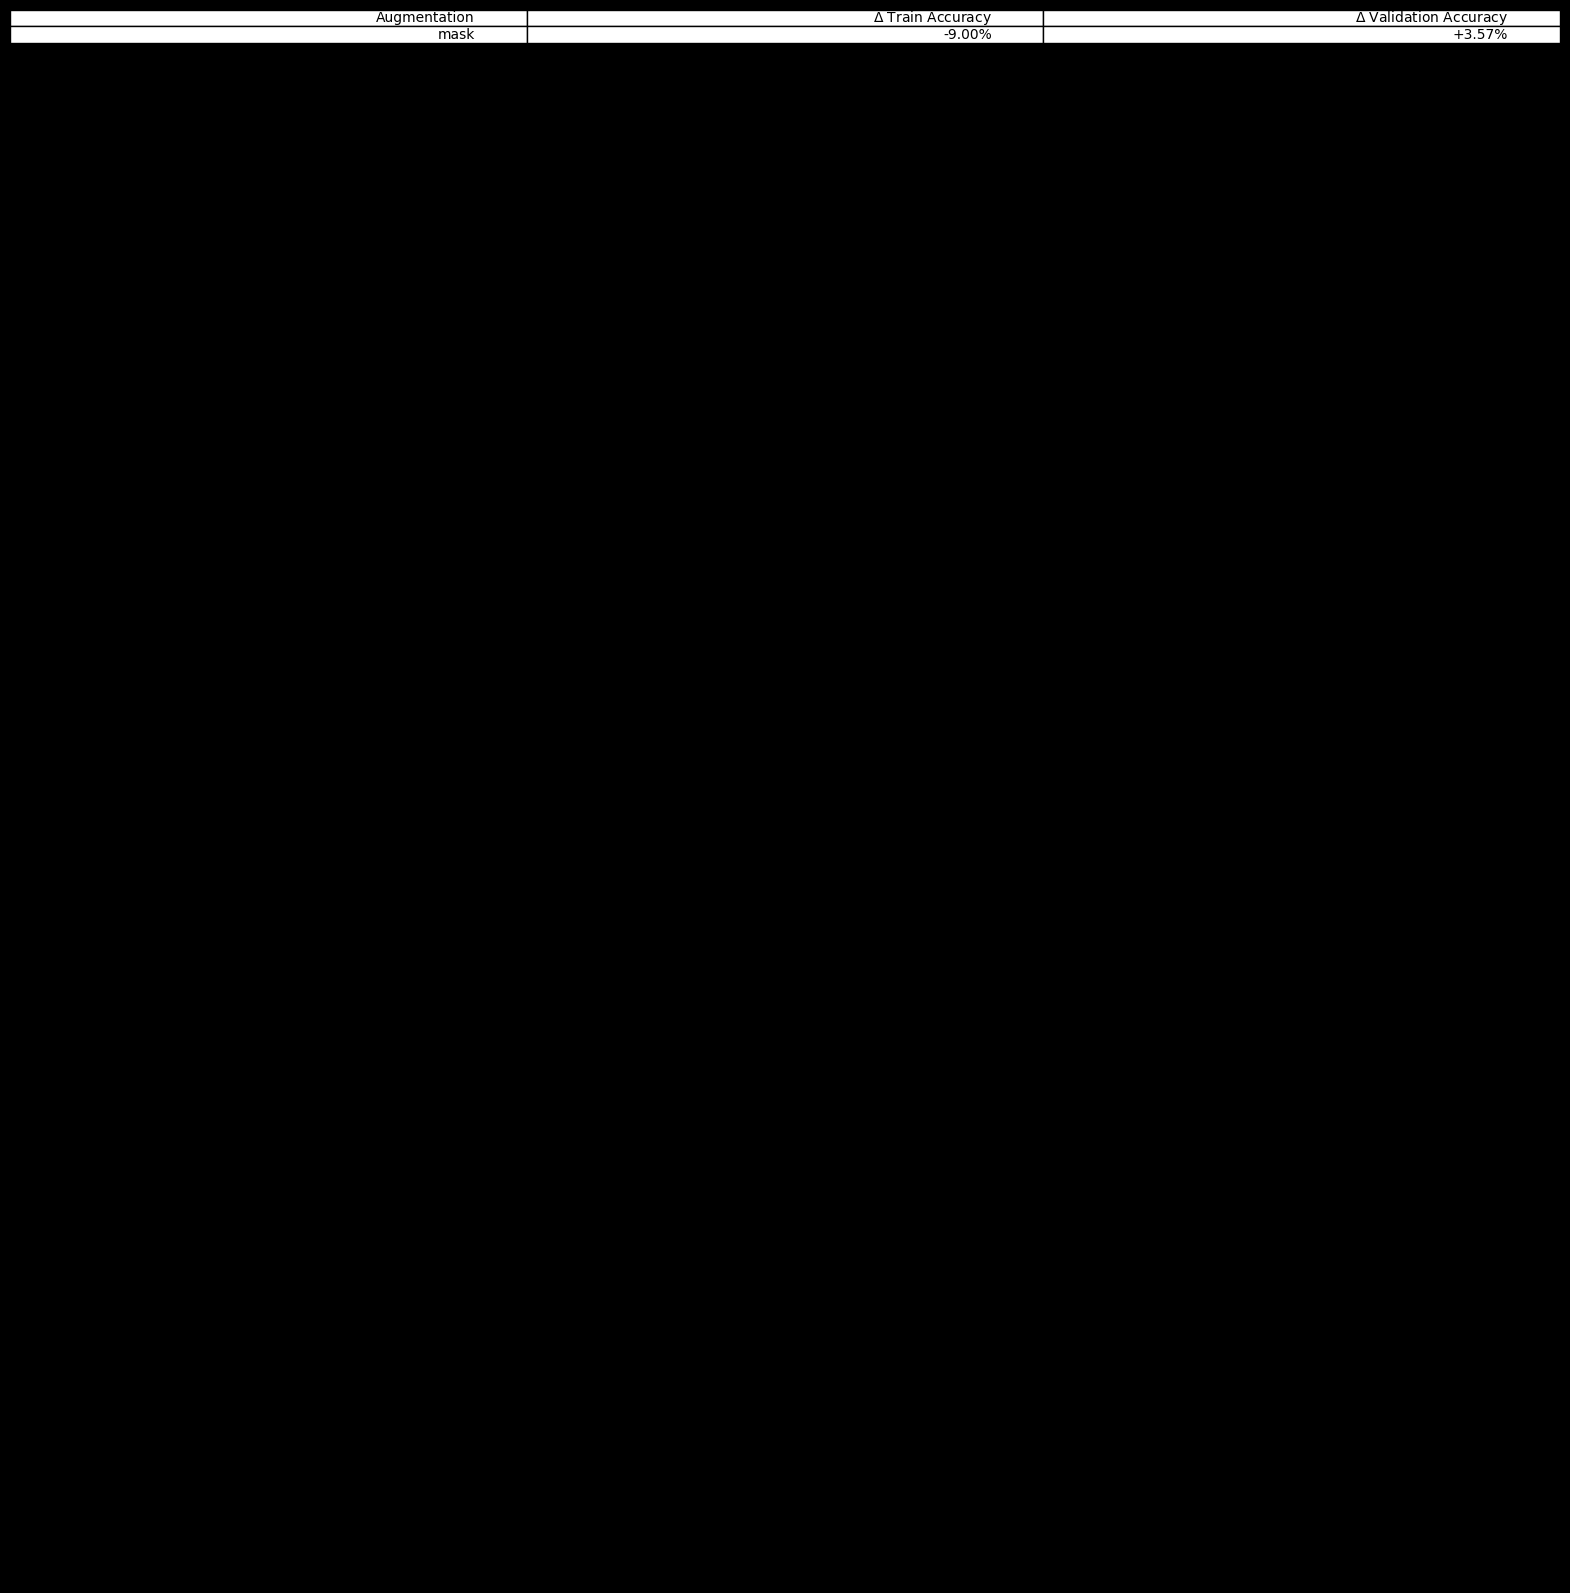

In [38]:
import matplotlib.pyplot as plt

def generate_data_augment_table(root, augmentations, baseline='plain', fig_name='result.png'):
  table = [['Augmentation', r'$\Delta$ Train Accuracy', r'$\Delta$ Validation Accuracy']]

  baseline_ckpt = torch.load(os.path.join(root, f"{baseline}.ckpt"))
  baseline_ta = baseline_ckpt["train_accuracy"]
  baseline_va = baseline_ckpt["val_accuracy"]

  for aug in augmentations:
    checkpoint = torch.load(os.path.join(root, f"{aug}.ckpt"))
    train_accuracy = checkpoint["train_accuracy"]
    val_accuracy = checkpoint["val_accuracy"]

    train_diff_perc = (train_accuracy - baseline_ta) * 100
    val_diff_perc = (val_accuracy - baseline_va) * 100

    train_diff_sign = '+' if train_diff_perc >= 0 else ''
    val_diff_sign = '+' if val_diff_perc >= 0 else ''

    table.append([aug, f'{train_diff_sign}{train_diff_perc:.2f}%', f'{val_diff_sign}{val_diff_perc:.2f}%'])
  
  fig, ax = plt.subplots(figsize=(10, 10), facecolor='black')
  ax.axis("off")
  table = ax.table(cellText=table, loc='top')
  plt.savefig(os.path.join(root, fig_name))
  plt.show()

generate_data_augment_table('results', ['vertical_flip', 'horizontal_flip', 'rotate', 'crop', 'jitter', 'gaus'], fig_name='data_augmentations.png')
generate_data_augment_table('results', ['mask'], baseline='no_mask', fig_name='masking.png')